## This whole notebook is based off of the steps seen **[here](https://anomaly.io/seasonal-trend-decomposition-in-r/index.html)**. For the purpose of simplicity this is just a replication of the logic for ONLY the `"additive"` behavior of R's `decompose` as opposed to the `"multiplicative"` behavior.

For this example, we use the `ausbeer` dataset. Its seasonal variation seems constant so we use the `additive` decomposition behavior. If its seasonal variation were to increase with time we would look into using the `multiplicative` decomposition behavior.

## Setup

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pmdarima.datasets import load_ausbeer

In [2]:
ausbeer = load_ausbeer()

## Step 1: Import the Data 

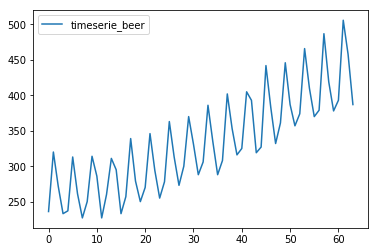

In [3]:
# We use the head and tail naming index because this is how the example names them.
head_index = 17*4+2
tail_index = 17*4-4
first_index = head_index - tail_index
last_index = head_index
timeserie_beer = ausbeer[first_index:last_index]
plt.plot(timeserie_beer, label="timeserie_beer")
plt.legend()
plt.show()

## Step 2: Detect the Trend

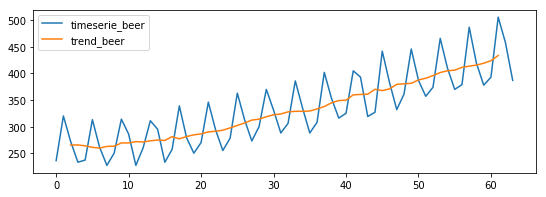

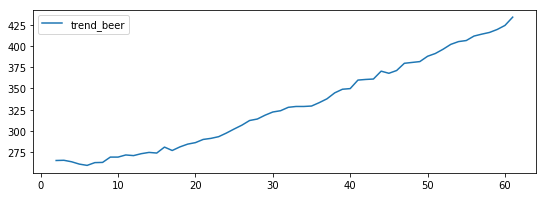

In [4]:
# We mimic the centered SMA behavior over the quarterly data.
N = 4 # quarterly
half_N = int(N/2.)
trend_beer = np.convolve(timeserie_beer, np.ones((N,))/N, mode='valid')
trend_beer = trend_beer[:-1] # we remove the final index.
# The simple moving average is centered because it shifts from the 0th index to the N/2 index
moving_average_x = range(half_N, len(trend_beer) + half_N)
# Plot the original signal with the trend
plt.figure(figsize=(9,3))
plt.plot(timeserie_beer, label="timeserie_beer")
plt.plot(moving_average_x, trend_beer, label="trend_beer")
plt.legend()
plt.show()
plt.figure(figsize=(9,3))
plt.plot(moving_average_x, trend_beer, label="trend_beer")
plt.legend()
plt.show()

## Step 3: Detrend the Time Series

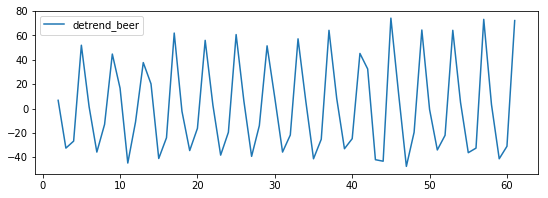

In [5]:
# Remove the effects of the trend and then plot.
detrend_beer = timeserie_beer[moving_average_x] - trend_beer
plt.figure(figsize=(9,3))
plt.plot(moving_average_x, detrend_beer, label="detrend_beer")
plt.legend()
plt.show()

## Step 4: Average the Seasonality

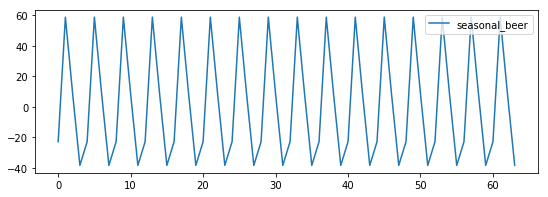

In [6]:

# Reshape the array to 15 by 4 so that it reflects the quarters over the 60 points
# from the range of points that overlap the SMA.
m_beer = np.reshape(detrend_beer, (int(detrend_beer.shape[0] / N), N))

# We take the mean with respect to the columns / quarters and then shift the quarters
# This is due to the math of the centered SMA that we have to do the offset of 2.
seasonal_beer = np.nanmean(m_beer, axis=0).tolist()
seasonal_beer = np.array(seasonal_beer[half_N:] + seasonal_beer[:half_N])

# Build 16 cycles before plotting so that we get back to 64 points
# i = 0, we build an array of 2 seasons
# i = 1, we build an array of 4 seasons
# i = 2, we build an array of 8 seasons
# i = 3, we build an array of 16 seasons and then stop
for i in range(4):
    seasonal_beer = np.concatenate((seasonal_beer, seasonal_beer))

# Plot the seasonal beer count. This should be a repetitive pattern with period 4, and cycles=16
plt.figure(figsize=(9,3))
plt.plot(seasonal_beer, label="seasonal_beer")
plt.legend()
plt.show()

## Step 5: Examining Remaining Random Noise

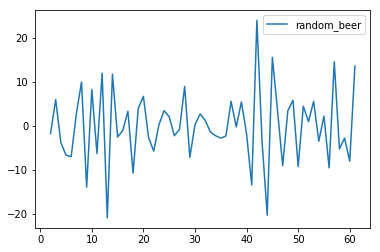

In [7]:
# Add NaN to beginning and end of time series to make the dimensions match for array subtraction.
# This buffer is created relative to half the size of N.
buffer = []
for i in range(half_N):
    buffer.append(np.nan)
trend_beer_buffered = np.array(buffer + trend_beer.tolist() + buffer)

# Subtract the effects of the trend and the seasonality to get the remaining noise/randomness of the time series
random_beer = timeserie_beer - trend_beer_buffered - seasonal_beer
plt.plot(random_beer, label="random_beer")
plt.legend()
plt.show()

## Step 6: Reconstruct the Original Signal

### Recomposed Signal
- **FYI: It is okay that there are missing points because the SMA has leading and lagging points removed**

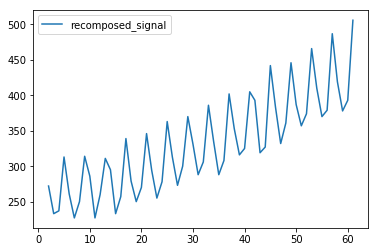

In [8]:
recomposed_signal = trend_beer_buffered + seasonal_beer + random_beer
plt.plot(recomposed_signal, label="recomposed_signal")
plt.legend()
plt.show()

### Original Signal

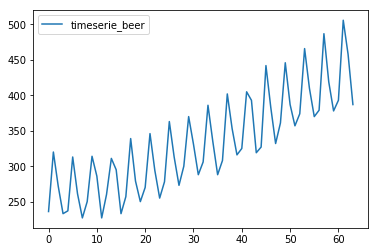

In [9]:
plt.plot(timeserie_beer, label="timeserie_beer")
plt.legend()
plt.show()

## Assert `decompose` matches generated output which matches R's implementation of `decompose` 

In [10]:
from pmdarima.arima.seasonality import decompose
from numpy.testing import assert_array_equal, assert_array_almost_equal
decomposed = decompose(timeserie_beer, 'additive', f=4)

assert_array_equal(decomposed.x, timeserie_beer)
assert_array_equal(decomposed.trend, trend_beer_buffered)
assert_array_equal(decomposed.seasonal, seasonal_beer)
assert_array_almost_equal(decomposed.random, random_beer, decimal=100)

Using 'module://ipykernel.pylab.backend_inline' MPL backend


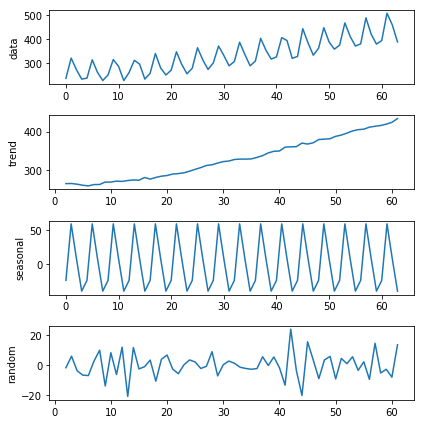

In [11]:
from pmdarima.utils.visualization import decomposed_plot

figure_kwargs = {'figsize': (6, 6)}
decomposed_plot(decomposed, **figure_kwargs)